# Tutorial Image Generator

This notebook produces all the explanatory images used in Tutorials 1 and 2.  
Run all cells to regenerate the images into the `images/` folder.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

IMG_DIR = Path("images")
IMG_DIR.mkdir(exist_ok=True)

# Consistent styling
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 13,
})

---
## 1. Cut-off Power Law (Schechter-like Luminosity Function)

Used in **Tutorial 1** to explain the energy/luminosity distribution parameter $k$.

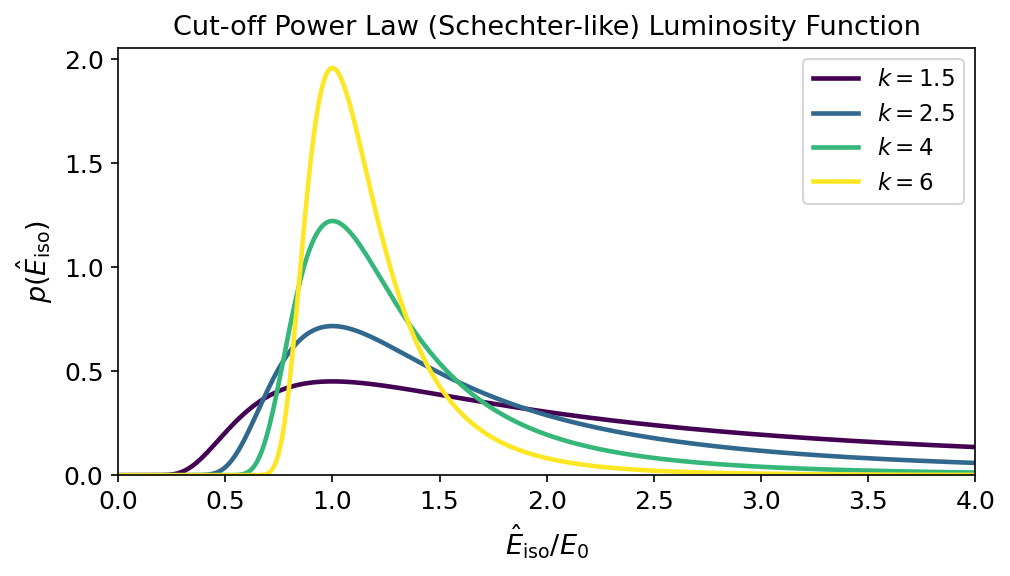

In [18]:
def cutoff_power_law(x, k, x0=1.0):
    """Schechter-like: p(x) ∝ x^(k-1) * exp(-k * x)  (for x > 0)."""
    return x**(-k) * np.exp(- (x / x0)**-k)

x = np.linspace(0.01, 4, 500)

fig, ax = plt.subplots(figsize=(7, 4))
for k_val, color in zip([1.5, 2.5, 4, 6], ['#440154', '#31688e', '#35b779', '#fde725']):
    y = cutoff_power_law(x, k_val)
    y /= np.trapz(y, x)
    ax.plot(x, y, lw=2.2, label=f'$k = {k_val}$', color=color)

ax.set_xlabel(r'$\hat{E}_{\rm iso} / E_0$')
ax.set_ylabel(r'$p(\hat{E}_{\rm iso})$')
ax.set_title('Cut-off Power Law (Schechter-like) Luminosity Function')
ax.legend(fontsize=11)
ax.set_xlim(0, 4)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(IMG_DIR / 'cutoff_power_law.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 2. Top-Hat $\theta_c$ Distribution (Flat from 1° to $\theta_{c,\max}$)

Used in **Tutorial 1** to show the uniform core-angle window.

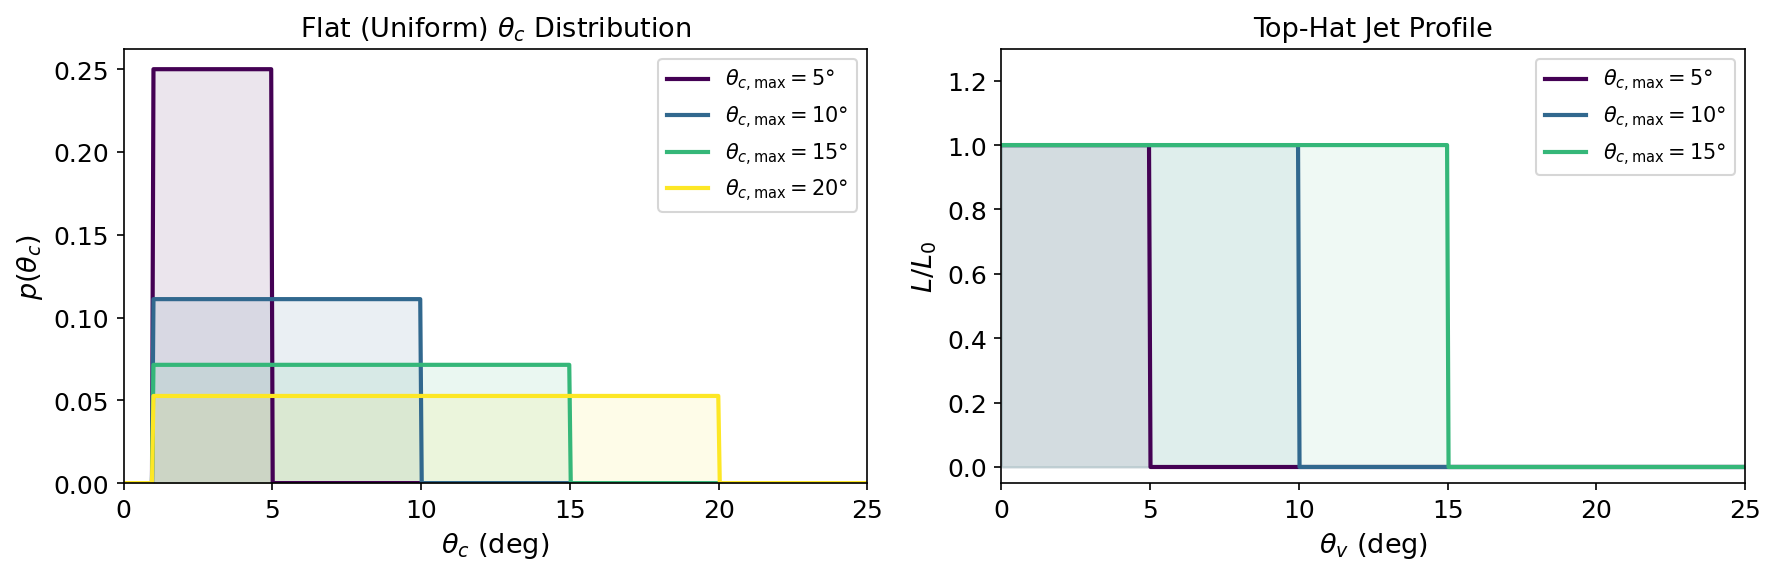

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: flat theta_c distribution
theta_min = 1.0
for theta_max, c in zip([5, 10, 15, 20], ['#440154', '#31688e', '#35b779', '#fde725']):
    theta = np.linspace(0, 25, 500)
    pdf = np.where((theta >= theta_min) & (theta <= theta_max),
                   1.0 / (theta_max - theta_min), 0.0)
    axes[0].plot(theta, pdf, lw=2, label=rf'$\theta_{{c,\max}} = {theta_max}°$', color=c)
    axes[0].fill_between(theta, pdf, alpha=0.1, color=c)

axes[0].set_xlabel(r'$\theta_c$ (deg)')
axes[0].set_ylabel(r'$p(\theta_c)$')
axes[0].set_title(r'Flat (Uniform) $\theta_c$ Distribution')
axes[0].legend(fontsize=10)
axes[0].set_xlim(0, 25)
axes[0].set_ylim(bottom=0)

# Right: resulting jet profile (luminosity vs viewing angle)
theta_v = np.linspace(0, 25, 500)
for theta_max, c in zip([5, 10, 15], ['#440154', '#31688e', '#35b779']):
    profile = np.where(theta_v <= theta_max, 1.0, 0.0)
    axes[1].plot(theta_v, profile, lw=2, color=c,
                 label=rf'$\theta_{{c,\max}} = {theta_max}°$')
    axes[1].fill_between(theta_v, profile, alpha=0.08, color=c)

axes[1].set_xlabel(r'$\theta_v$ (deg)')
axes[1].set_ylabel(r'$L / L_0$')
axes[1].set_title('Top-Hat Jet Profile')
axes[1].legend(fontsize=10)
axes[1].set_xlim(0, 25)
axes[1].set_ylim(-0.05, 1.3)

plt.tight_layout()
plt.savefig(IMG_DIR / 'tophat_theta_distribution.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 3. Cramér–von Mises (CvM) Test — ECDF Distance

Used in both tutorials to explain the goodness-of-fit statistic.

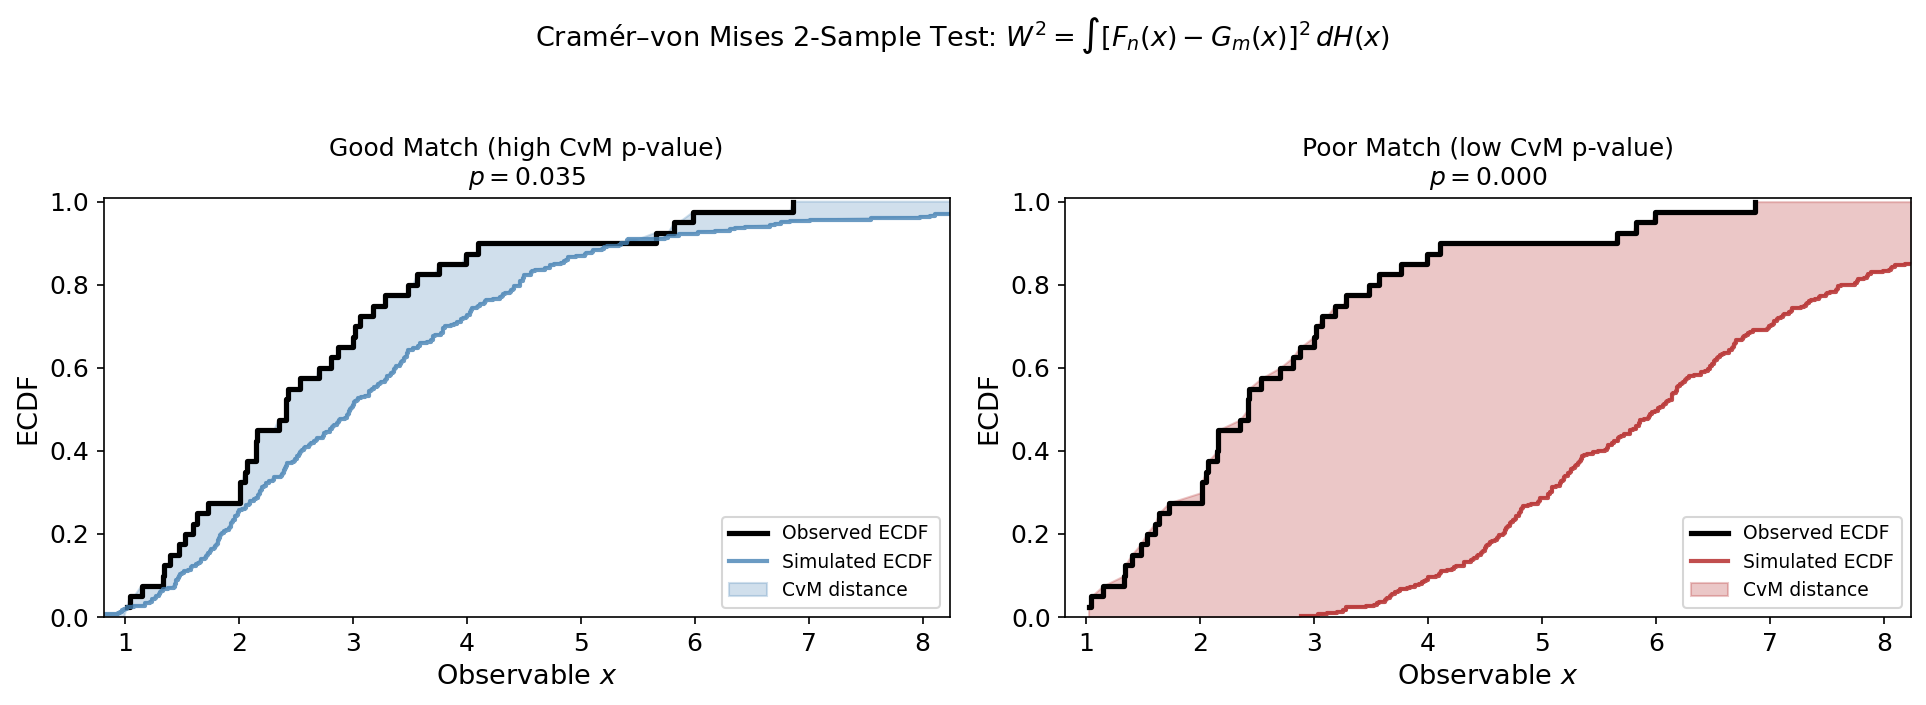

In [20]:
np.random.seed(42)

# "Observed" data
obs = np.sort(np.random.lognormal(1.0, 0.5, 40))
# "Simulated" — close match
sim_good = np.sort(np.random.lognormal(1.05, 0.55, 300))
# "Simulated" — poor match
sim_bad  = np.sort(np.random.lognormal(1.8, 0.3, 300))

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

for ax, sim, title, color in zip(axes,
                                  [sim_good, sim_bad],
                                  ['Good Match (high CvM p-value)',
                                   'Poor Match (low CvM p-value)'],
                                  ['steelblue', 'firebrick']):
    xo, yo = ecdf(obs)
    xs, ys = ecdf(sim)

    ax.step(xo, yo, where='post', lw=2.5, color='black', label='Observed ECDF')
    ax.step(xs, ys, where='post', lw=2, color=color, alpha=0.8, label='Simulated ECDF')

    # Shade the area between the two ECDFs at a few points
    combined = np.sort(np.concatenate([xo, xs]))
    ecdf_obs_interp = np.searchsorted(xo, combined, side='right') / len(xo)
    ecdf_sim_interp = np.searchsorted(xs, combined, side='right') / len(xs)
    ax.fill_between(combined, ecdf_obs_interp, ecdf_sim_interp,
                    alpha=0.25, color=color, label='CvM distance')

    # Compute p-value
    pval = stats.cramervonmises_2samp(np.log10(obs), np.log10(sim)).pvalue
    ax.set_title(f'{title}\n$p = {pval:.3f}$', fontsize=12)
    ax.set_xlabel('Observable $x$')
    ax.set_ylabel('ECDF')
    ax.legend(fontsize=9, loc='lower right')
    # because the samples don't cover the whole range just plot xlim between the min and max of sim data not true
    ax.set_xlim(xo.min() * 0.8, xo.max() * 1.2)
    ax.set_ylim(0, 1.01)

plt.suptitle(r'Cramér–von Mises 2-Sample Test: $W^2 = \int [F_n(x) - G_m(x)]^2\,dH(x)$',
             fontsize=13, y=1.04)
plt.tight_layout()
plt.savefig(IMG_DIR / 'cvm_ecdf_explanation.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 4. Smoothly Broken Power Law (SBPL) Spectrum

Used in **Tutorial 1 & 2** to show the spectral model.

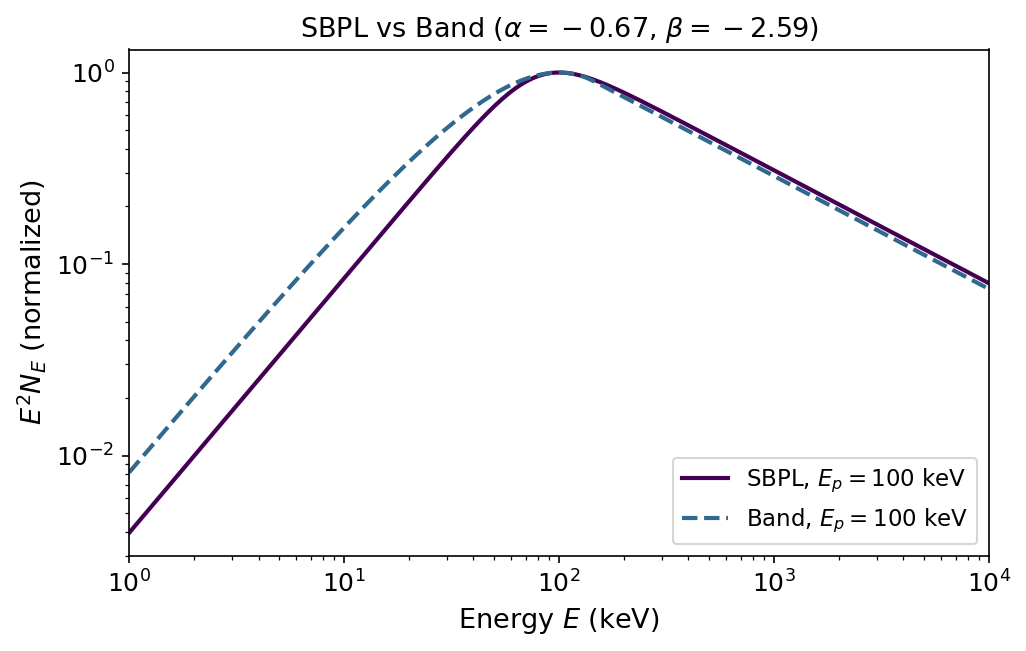

In [27]:
def sbpl(E, E_p, alpha=-0.67, beta=-2.59, n=2):
    """Smoothly broken power law N_E."""
    eps = (-(2 + alpha) / (2 + beta))**(1 / (n * (alpha - beta)))
    y = E / (E_p / eps)
    C_n = 2**(1 / n)
    return C_n * (y**(-alpha * n) + y**(-beta * n))**(-1 / n)

def band(E, E_p, alpha=-0.67, beta=-2.59):
    """Band function N_E."""
    E0 = E_p / (2 + alpha)
    E_break = (alpha - beta) * E0
    
    low = (E / 100)**alpha * np.exp(-(2 + alpha) * E / E_p)
    high = (E / 100)**beta * np.exp(beta - alpha) * (
        (alpha - beta) * E_p / (100 * (2 + alpha))
    )**(alpha - beta)
    
    return np.where(E < E_break, low, high)

E = np.logspace(0, 4, 1000)  # 1 keV to 10 MeV

fig, ax = plt.subplots(figsize=(7, 4.5))
ep = 100  # keV

y_sbpl = sbpl(E, ep)
y_band = band(E, ep)

# Normalize both to peak at 1 for comparison
y_sbpl_norm = E**2 * y_sbpl
y_band_norm = E**2 * y_band
y_sbpl_norm /= y_sbpl_norm.max()
y_band_norm /= y_band_norm.max()

ax.loglog(E, y_sbpl_norm, lw=2, color='#440154', ls='-',
          label=rf'SBPL, $E_p = {ep}$ keV')
ax.loglog(E, y_band_norm, lw=2, color='#31688e', ls='--',
          label=rf'Band, $E_p = {ep}$ keV')

ax.set_xlabel('Energy $E$ (keV)')
ax.set_ylabel(r'$E^2 N_E$ (normalized)')
ax.set_title(r'SBPL vs Band ($\alpha = -0.67$, $\beta = -2.59$)')
ax.legend(fontsize=11)
ax.set_xlim(1, 1e4)
plt.tight_layout()
plt.savefig(IMG_DIR / 'sbpl_spectrum.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 5. $f_j$ Explanation Diagram

Used in **Tutorial 1** to explain the jet fraction parameter.

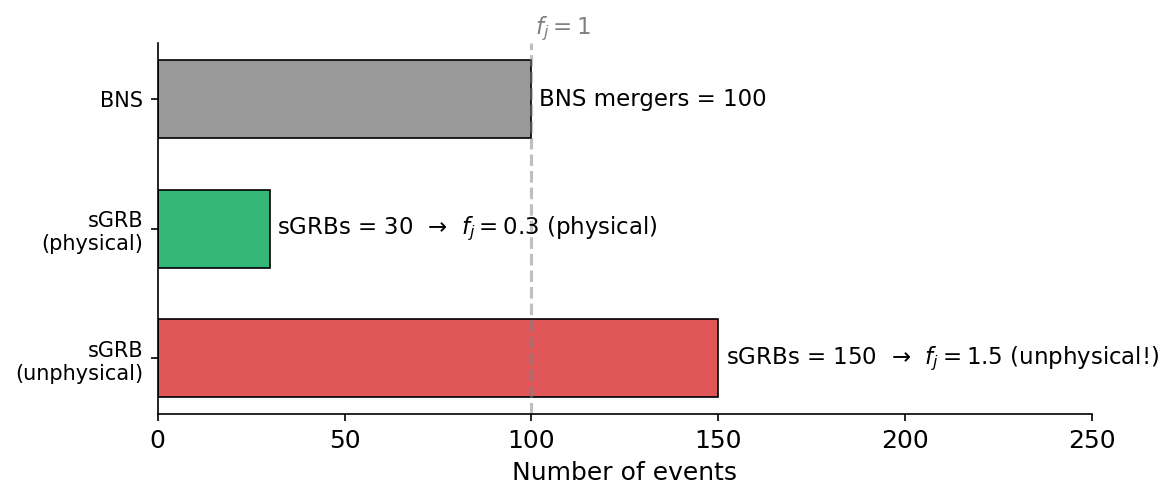

In [22]:
fig, ax = plt.subplots(figsize=(8, 3.5))

# BNS mergers bar
n_bns = 100
n_grb_phys = 30    # fj = 0.3
n_grb_unphys = 150 # fj = 1.5

bar_y = [2, 1, 0]
bar_w = [n_bns, n_grb_phys, n_grb_unphys]
colors = ['#999999', '#35b779', '#e15759']
labels = [f'BNS mergers = {n_bns}',
          f'sGRBs = {n_grb_phys}  →  $f_j = {n_grb_phys/n_bns}$ (physical)',
          f'sGRBs = {n_grb_unphys}  →  $f_j = {n_grb_unphys/n_bns}$ (unphysical!)']

bars = ax.barh(bar_y, bar_w, height=0.6, color=colors, edgecolor='k', linewidth=0.8)

for b, lbl in zip(bars, labels):
    ax.text(b.get_width() + 2, b.get_y() + b.get_height()/2,
            lbl, va='center', fontsize=11)

ax.set_xlim(0, 250)
ax.set_yticks(bar_y)
ax.set_yticklabels(['BNS', 'sGRB\n(physical)', 'sGRB\n(unphysical)'], fontsize=10)
ax.set_xlabel('Number of events', fontsize=12)
ax.axvline(n_bns, ls='--', color='grey', alpha=0.5, lw=1.5)
ax.text(n_bns + 1, 2.5, r'$f_j = 1$', fontsize=11, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(IMG_DIR / 'fj_explanation.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 6. Structured Jet Angular Profile

Used in **Tutorial 2** to explain the angular energy/flux structure.

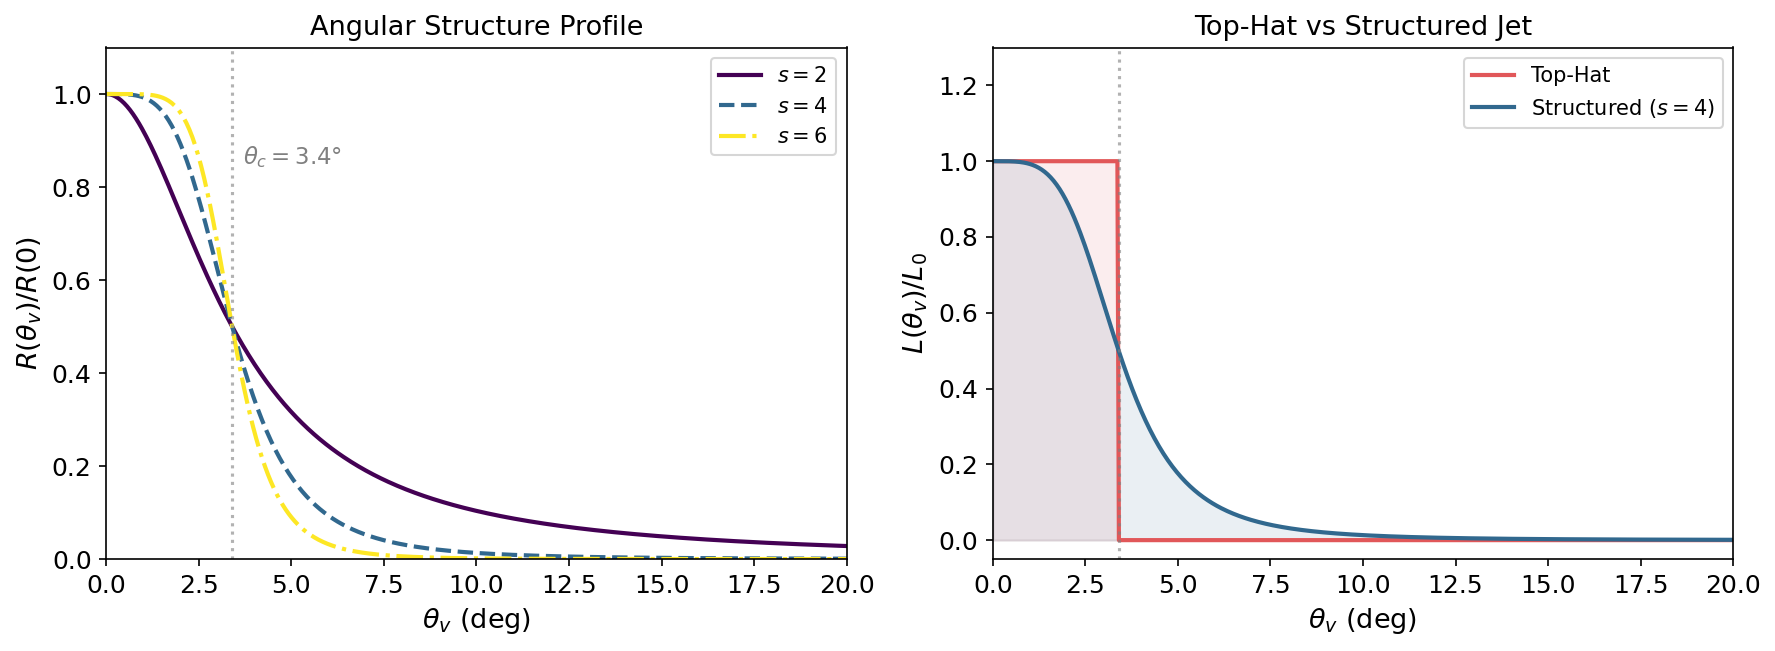

In [23]:
def structured_profile(theta, theta_c, s=4.0):
    """Gaussian-like angular profile: R(θ) = 1 / (1 + (θ/θ_c)^s)."""
    return 1.0 / (1.0 + (theta / theta_c)**s)

theta = np.linspace(0, 20, 500)
theta_c = 3.4  # deg, from GW170817

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: energy/flux angular profiles
for s, c, ls in zip([2, 4, 6], ['#440154', '#31688e', '#fde725'], ['-', '--', '-.']):
    axes[0].plot(theta, structured_profile(theta, theta_c, s), lw=2,
                 color=c, ls=ls, label=f'$s = {s}$')

axes[0].axvline(theta_c, ls=':', color='grey', alpha=0.6)
axes[0].text(theta_c + 0.3, 0.85, rf'$\theta_c = {theta_c}°$', fontsize=11, color='grey')
axes[0].set_xlabel(r'$\theta_v$ (deg)')
axes[0].set_ylabel(r'$R(\theta_v) / R(0)$')
axes[0].set_title('Angular Structure Profile')
axes[0].legend(fontsize=10)
axes[0].set_xlim(0, 20)
axes[0].set_ylim(0, 1.1)

# Right: compare top-hat vs structured
tophat = np.where(theta <= theta_c, 1.0, 0.0)
struct = structured_profile(theta, theta_c, s=4)
axes[1].plot(theta, tophat, lw=2, color='#e15759', label='Top-Hat')
axes[1].plot(theta, struct, lw=2, color='#31688e', label='Structured ($s=4$)')
axes[1].fill_between(theta, tophat, alpha=0.1, color='#e15759')
axes[1].fill_between(theta, struct, alpha=0.1, color='#31688e')
axes[1].axvline(theta_c, ls=':', color='grey', alpha=0.6)
axes[1].set_xlabel(r'$\theta_v$ (deg)')
axes[1].set_ylabel(r'$L(\theta_v) / L_0$')
axes[1].set_title('Top-Hat vs Structured Jet')
axes[1].legend(fontsize=10)
axes[1].set_xlim(0, 20)
axes[1].set_ylim(-0.05, 1.3)

plt.tight_layout()
plt.savefig(IMG_DIR / 'structured_jet_profile.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 7. Structured Jet: Temporal Profile (Light Curve)

Used in **Tutorial 2** to illustrate the pulse shape: constant until $t_p$, then power-law decay.

> **TODO**: Replace this schematic with a real fit from a bright sGRB (e.g., GRB 090510).

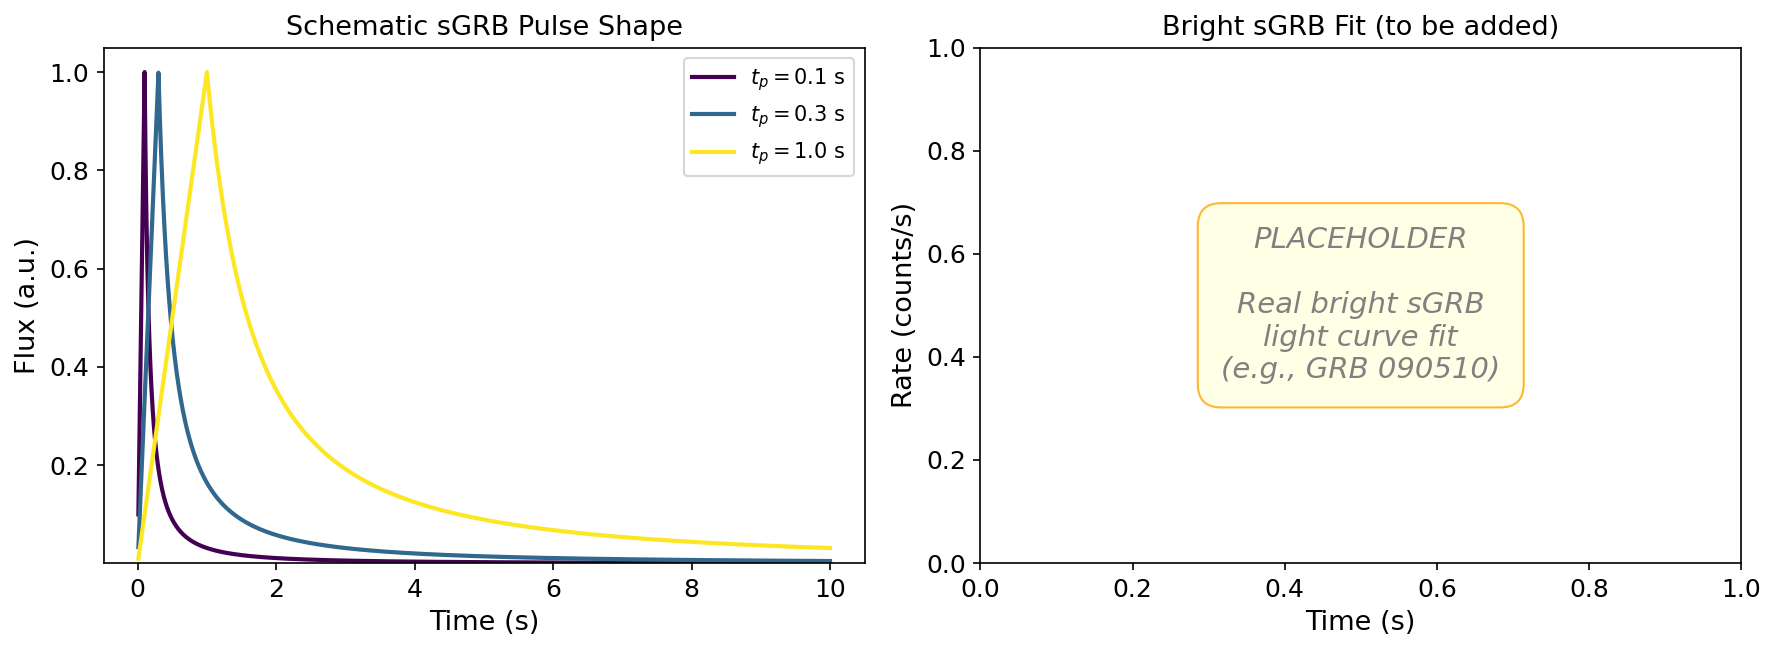

In [24]:
def schematic_lightcurve(t, t_p=0.3, F_peak=1.0, decay_index=-1.5):
    """Schematic sGRB pulse: rise to t_p then power-law decay."""
    F = np.zeros_like(t)
    rise = t <= t_p
    decay = t > t_p
    # simple linear rise
    F[rise] = F_peak * (t[rise] / t_p)
    # power-law decay
    F[decay] = F_peak * (t[decay] / t_p)**decay_index
    return F

t = np.logspace(-2, 1, 1000)  # 10 ms to 10 s

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: schematic light curves for different t_p
for tp, c in zip([0.1, 0.3, 1.0], ['#440154', '#31688e', '#fde725']):
    axes[0].loglog(t, schematic_lightcurve(t, t_p=tp), lw=2, color=c,
                    label=rf'$t_p = {tp}$ s')

axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Flux (a.u.)')
axes[0].set_title('Schematic sGRB Pulse Shape')
axes[0].legend(fontsize=10)
axes[0].set_ylim(1e-3, 1.05)
axes[0].set_xscale('linear')
axes[0].set_yscale('linear')

# Right: placeholder for real bright sGRB light curve fit
axes[1].text(0.5, 0.5,
             'PLACEHOLDER\n\nReal bright sGRB\nlight curve fit\n(e.g., GRB 090510)',
             transform=axes[1].transAxes, ha='center', va='center',
             fontsize=14, color='grey', style='italic',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow',
                       edgecolor='orange', alpha=0.8))
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Rate (counts/s)')
axes[1].set_title('Bright sGRB Fit (to be added)')

plt.tight_layout()
plt.savefig(IMG_DIR / 'temporal_profile.png', dpi=200, bbox_inches='tight')
plt.show()

---
## 8. Peak Energy ($E_p$) Log-Normal Distribution

Used in **Tutorial 1 & 2** to explain `L_mu_E` and `sigma_E`.

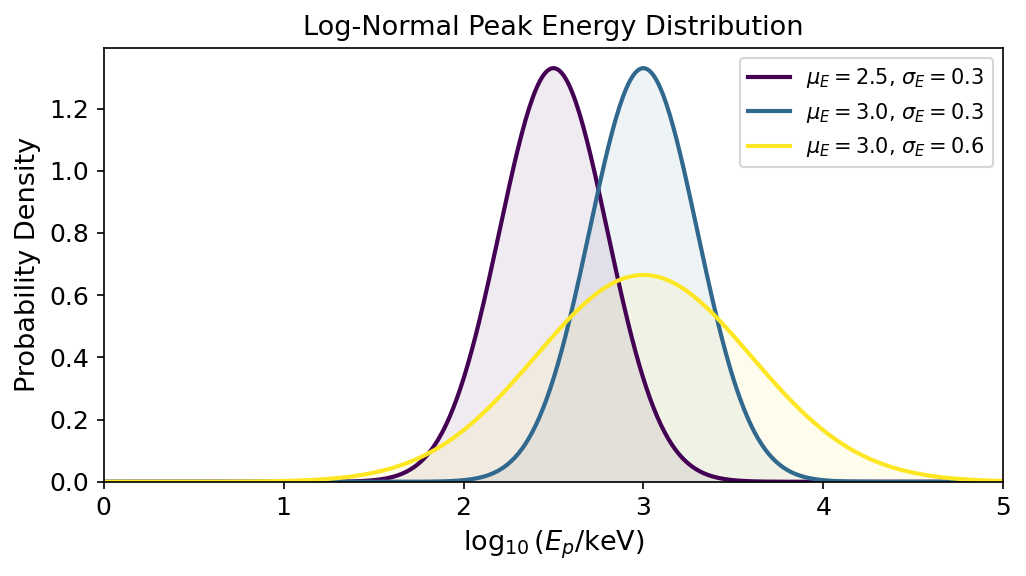

In [25]:
log_Ep = np.linspace(0, 5, 500)  # log10(Ep/keV)

fig, ax = plt.subplots(figsize=(7, 4))

for (mu, sig), c in zip([(2.5, 0.3), (3.0, 0.3), (3.0, 0.6)],
                         ['#440154', '#31688e', '#fde725']):
    pdf = stats.norm.pdf(log_Ep, loc=mu, scale=sig)
    ax.plot(log_Ep, pdf, lw=2, color=c,
            label=rf'$\mu_E = {mu}$, $\sigma_E = {sig}$')
    ax.fill_between(log_Ep, pdf, alpha=0.08, color=c)

ax.set_xlabel(r'$\log_{10}(E_p / \mathrm{keV})$')
ax.set_ylabel('Probability Density')
ax.set_title(r'Log-Normal Peak Energy Distribution')
ax.legend(fontsize=10)
ax.set_xlim(0, 5)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(IMG_DIR / 'epeak_distribution.png', dpi=200, bbox_inches='tight')
plt.show()

---
## Done!

All images saved to `images/`. These are referenced by the tutorials via:
```markdown
![description](images/filename.png)
```